In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 去除雜訊

In [2]:
def RemoveNoise(dataset, remove_condition):
    # Remove data with gaze vector X, Y, Z have value 0.
    print(f'Total count: {len(dataset)}, gaze vector zero count: {len(dataset[remove_condition])}')

    dataset = dataset.drop(dataset[remove_condition].index)

    print(f'Total count: {len(dataset)}')
    
    return dataset

## 載入資料集

In [3]:
import os
df_train = pd.core.frame.DataFrame()
for dirname, _, filenames in os.walk('/project/xt121-group5/scene2_data/'):
    for filename in filenames:
        if dirname.split('/')[-1] != 'test_data':
            print(os.path.join(dirname, filename))
            df_train2 = pd.read_csv(os.path.join(dirname, filename))
            df_train2 = RemoveNoise(df_train2, 
                                    (df_train2['GazeVector_X'] == 0) & 
                                    (df_train2['GazeVector_Y'] == 0) & 
                                    (df_train2['GazeVector_Z'] == 0))
            df_train = pd.concat([df_train, df_train2])
        
df_train = df_train.drop(labels = ['RecordTime'], axis = 1) # 移除 RecordTime

/project/xt121-group5/scene2_data/alice/2023-05-01 232058.csv
Total count: 420, gaze vector zero count: 311
Total count: 109
/project/xt121-group5/scene2_data/alice/2023-05-01 231925.csv
Total count: 412, gaze vector zero count: 16
Total count: 396
/project/xt121-group5/scene2_data/pinsian/2023-05-13 142553_c.csv
Total count: 280, gaze vector zero count: 0
Total count: 280
/project/xt121-group5/scene2_data/pinsian/2023-05-13 142611 nc.csv
Total count: 280, gaze vector zero count: 28
Total count: 252
/project/xt121-group5/scene2_data/larry/2023-05-01 232448.csv
Total count: 469, gaze vector zero count: 0
Total count: 469
/project/xt121-group5/scene2_data/larry/2023-05-01 232329.csv
Total count: 305, gaze vector zero count: 0
Total count: 305
/project/xt121-group5/scene2_data/charlie/2023-05-05 103150_c.csv
Total count: 655, gaze vector zero count: 0
Total count: 655
/project/xt121-group5/scene2_data/charlie/2023-05-17 103748.csv
Total count: 2186, gaze vector zero count: 901
Total count

In [4]:
print(df_train.shape)
print(df_train.groupby('RecordType')['RecordType'].count())

(14186, 103)
RecordType
0    6235
1    7951
Name: RecordType, dtype: int64


## 資料前處理

### 前處理－臉部特徵座標平移

In [5]:
def FaceLandmarksPreprocessing(df_data, verbose = False):
    for col_name in df_data.columns.to_list():
        if col_name.find('FaceLandmarks_') == 0 or \
        col_name.find('EyeLandmarks_') == 0 or \
        col_name.find('LeftEyeBoundingBox_') == 0 or \
        col_name.find('RightEyeBoundingBox_') == 0 or \
        col_name.find('LeftEyeMidPoint_') == 0 or \
        col_name.find('RightEyeMidPoint_') == 0:
            if col_name.find('_X') == len(col_name) - 2:
                df_data[col_name] = df_data[col_name] - df_data['FaceBoundingBox_X']
                if verbose:
                    print(f'Column {col_name} is subtracted by FaceBoundingBox_X.')
            elif col_name.find('_Y') == len(col_name) - 2:
                df_data[col_name] = df_data[col_name] - df_data['FaceBoundingBox_Y']
                if verbose:
                    print(f'Column {col_name} is subtracted by FaceBoundingBox_Y.')
            else:
#                 print(f'Ignore column {col_name}.')
                pass
        else:
#             print(f'Ignore column {col_name}')
            pass
    return df_data

In [6]:
print(df_train.head())

    FaceBoundingBox_X  FaceBoundingBox_Y  FaceBoundingBox_W  \
0                 524                166                253   
1                 525                161                255   
2                 525                163                255   
3                 526                168                255   
15                532                243                205   

    FaceBoundingBox_H  FaceLandmarks_1_X  FaceLandmarks_1_Y  \
0                 253                632                257   
1                 255                634                254   
2                 255                634                256   
3                 255                639                268   
15                205                632                366   

    FaceLandmarks_2_X  FaceLandmarks_2_Y  FaceLandmarks_3_X  \
0                 602                255                679   
1                 603                252                681   
2                 604                255             

In [7]:
df_train = FaceLandmarksPreprocessing(df_train, True)

Column FaceLandmarks_1_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_1_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_2_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_2_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_3_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_3_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_4_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_4_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_5_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_5_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_6_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_6_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_7_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_7_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_8_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_8_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_9_X

In [8]:
print(df_train.head())

    FaceBoundingBox_X  FaceBoundingBox_Y  FaceBoundingBox_W  \
0                 524                166                253   
1                 525                161                255   
2                 525                163                255   
3                 526                168                255   
15                532                243                205   

    FaceBoundingBox_H  FaceLandmarks_1_X  FaceLandmarks_1_Y  \
0                 253                108                 91   
1                 255                109                 93   
2                 255                109                 93   
3                 255                113                100   
15                205                100                123   

    FaceLandmarks_2_X  FaceLandmarks_2_Y  FaceLandmarks_3_X  \
0                  78                 89                155   
1                  78                 91                156   
2                  79                 92             

### 前處理－檢查缺失值

In [9]:
# checked missing data
print("Before data clean(NAN mount):", len(np.where(np.isnan(df_train) == 1)[0]))

Before data clean(NAN mount): 0


In [10]:
# Find columns with only unique value.
# unique_col = []
# for i in df_train.columns:
#     if np.unique(df_train[i]).shape[0]==1:
#         print(f'Get column {i} with only unique value.')
#         unique_col.append(i) 

In [11]:
# print(unique_col)

In [12]:
# df_train.describe()[unique_col]

In [13]:
# Drop columns with only unique value.
# df_train = df_train.drop(unique_col, axis=1)

### 前處理－保留重要特徵

In [14]:
# 列出重要的特徵。
col_high_rel = ['HeadPoseAngles_Y', 'GazeVector_X', 'GazeVector_Z', 'GazeVector_Y', 'HeadPoseAngles_Z']
col_deleted = ['FaceBoundingBox_X', 'FaceBoundingBox_Y']

In [15]:
# 取目標值。
y = df_train['RecordType'].values
print(y.shape)

(14186,)


In [16]:
# 刪除沒有被列在重要特徵列表的特徵。
def ReserveImportColumns(df_data, col_reserved):
    for col_name in df_data.columns.to_list():
        if col_name not in col_reserved:
            df_data = df_data.drop(col_name, axis = 1)
    return df_data

In [17]:
df_train.drop(col_deleted, axis = 1)
df_train = ReserveImportColumns(df_train, col_high_rel)

print(shape(df_train))
print(df_train.columns)

(14186, 5)
Index(['HeadPoseAngles_Y', 'HeadPoseAngles_Z', 'GazeVector_X', 'GazeVector_Y',
       'GazeVector_Z'],
      dtype='object')


In [18]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

In [19]:
# def data_preprocessing(df_input, train=True, sc=None):
#     # numeric feature standardization
#     if train:
#         sc = StandardScaler()
# #         sc = MinMaxScaler()
#         df = sc.fit_transform(df_input.iloc[:, 0:-1])
#     else:
#         df = sc.transform(df_input)
#     return df, sc

In [20]:
# X, train_sc = data_preprocessing(df_train)

In [21]:
# print(X.shape)

In [22]:
# print(train_sc.mean_)

In [23]:
# print(train_sc.var_)

In [24]:
np.unique(y)
print(y)

[0 0 0 ... 1 1 1]


## 切割訓練集

In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(df_train, y, test_size = 0.25, random_state = 17, stratify = y)

## 訓練模型

In [26]:
# eval_metrics can selecy rmse, logloss, error,\
# auc, merror, mlogloss or custom define
eval_set = [(x_valid, y_valid)]
model = XGBClassifier(early_stopping_rounds = 10, 
                      eval_metric = "auc")
print(type(x_train))
print(type(y_train))
model.fit(x_train, 
          y_train, 
          eval_set = eval_set, 
          verbose = True)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[0]	validation_0-auc:0.945267
[1]	validation_0-auc:0.946899
[2]	validation_0-auc:0.952149
[3]	validation_0-auc:0.95436
[4]	validation_0-auc:0.955778
[5]	validation_0-auc:0.957858
[6]	validation_0-auc:0.957993
[7]	validation_0-auc:0.960638
[8]	validation_0-auc:0.961015
[9]	validation_0-auc:0.961142
[10]	validation_0-auc:0.961871
[11]	validation_0-auc:0.961872
[12]	validation_0-auc:0.962942
[13]	validation_0-auc:0.963494
[14]	validation_0-auc:0.964893
[15]	validation_0-auc:0.965263
[16]	validation_0-auc:0.965403
[17]	validation_0-auc:0.966218
[18]	validation_0-auc:0.967146
[19]	validation_0-auc:0.967558
[20]	validation_0-auc:0.967678
[21]	validation_0-auc:0.967844
[22]	validation_0-auc:0.968171
[23]	validation_0-auc:0.971566
[24]	validation_0-auc:0.972003
[25]	validation_0-auc:0.972461
[26]	validation_0-auc:0.974751
[27]	validation_0-auc:0.976199
[28]	validation_0-auc:0.976381
[29]	validation_0-auc:0.978531
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [27]:
# model.predict_proba will return the probility
# model.predict will return the predict label (use 0.5 as threshold)
y_pred = model.predict_proba(x_valid)
y_pred[:5]

array([[3.2289505e-02, 9.6771049e-01],
       [3.1933963e-02, 9.6806604e-01],
       [9.9906772e-01, 9.3230413e-04],
       [3.4155786e-02, 9.6584421e-01],
       [1.4191604e-01, 8.5808396e-01]], dtype=float32)

In [28]:
# we use model.predict to get the label
y_pred = model.predict(x_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.05%


In [29]:
# f1 score
f1_score_value = f1_score(y_valid, y_pred)
print("f1 score: %.2f%%" % (f1_score_value * 100.0))

f1 score: 96.52%


In [30]:
# we can show the feature importances for our features
print(model.feature_importances_)

[0.08319025 0.1012467  0.06393696 0.11232767 0.63929844]


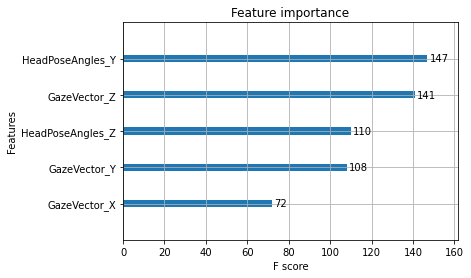

In [31]:
# import the plot_importance function to visualize the feature importance
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [32]:
!pip install graphviz

<Figure size 864x864 with 0 Axes>

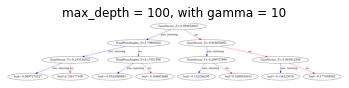

In [33]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

plt.figure(figsize=(12,12))
plot_tree(model, num_trees = 1)
plt.title("max_depth = 100, with gamma = 10")
plt.savefig("plot_tree_xgboost_norm_topn", dpi = 300)

## 模型測試

In [34]:
def GetScene2AccuractFromTest(arrTestAns, correctAns):
    accurate_rate = np.count_nonzero(arrTestAns == correctAns) / len(arrTestAns)
#     print(accurate_rate)
    return accurate_rate

In [35]:
# Test
# 測試一個答案全部為1的資料。
df_test = pd.read_csv('/project/xt121-group5/scene2_data/test_data/2023-05-17 194144 c.csv')
df_test = RemoveNoise(df_test, 
                      (df_test['GazeVector_X'] == 0) & 
                      (df_test['GazeVector_Y'] == 0) & 
                      (df_test['GazeVector_Z'] == 0))
df_test = FaceLandmarksPreprocessing(df_test)
df_test = df_test.drop(col_deleted, axis = 1)
df_test = ReserveImportColumns(df_test, col_high_rel)
# test, _ = data_preprocessing(df_test, train=False, sc=train_sc)

Total count: 1082, gaze vector zero count: 0
Total count: 1082


In [36]:
print(df_test.columns)
pred = model.predict(df_test)
print(pred.shape)
print(type(pred))

Index(['HeadPoseAngles_Y', 'HeadPoseAngles_Z', 'GazeVector_X', 'GazeVector_Y',
       'GazeVector_Z'],
      dtype='object')
(1082,)
<class 'numpy.ndarray'>


In [37]:
print(pred)
print(f'Test accurate rate: {GetScene2AccuractFromTest(pred, 1)}')

[1 1 1 ... 1 1 1]
Test accurate rate: 0.987985212569316


In [38]:
# Test
# 測試一個答案全部為0的資料。
# df_test = pd.read_csv('/project/xt121-group5/scene2_data/test_data/2023-05-06 135847_nc.csv')
df_test = pd.read_csv('/project/xt121-group5/scene2_data/test_data/2023-05-17 194223 nc.csv')
df_test = RemoveNoise(df_test, 
                      (df_test['GazeVector_X'] == 0) & 
                      (df_test['GazeVector_Y'] == 0) & 
                      (df_test['GazeVector_Z'] == 0))
df_test = FaceLandmarksPreprocessing(df_test)
df_test = df_test.drop(col_deleted, axis = 1)
df_test = ReserveImportColumns(df_test, col_high_rel)
# test, _ = data_preprocessing(df_test, train=False, sc=train_sc)

Total count: 956, gaze vector zero count: 70
Total count: 886


In [39]:
pred = model.predict(df_test)
print(pred)
print(f'Test accurate rate: {GetScene2AccuractFromTest(pred, 0)}')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

## 儲存模型

### 方法1. joblib

In [40]:
# Save model
import joblib
joblib.dump(model, './XGB_joblib_normalized_model')

# Load model
loaded_xgb_model = joblib.load('./XGB_joblib_normalized_model')
pred = loaded_xgb_model.predict(df_test)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### 方法2. save_model

In [41]:
# Save model
model.save_model('XGB_normalized_topn_model.json')

# Load model
import xgboost as xgb
model_xgb = xgb.XGBRegressor()
model_xgb.load_model('XGB_normalized_topn_model.json')
pred = model_xgb.predict(df_test)
print(pred)

[2.17353925e-02 1.07059833e-02 1.07059833e-02 1.07059833e-02
 1.07059833e-02 8.68879072e-03 8.45068041e-03 1.04131727e-02
 1.07059833e-02 8.45068041e-03 2.11473852e-02 2.11473852e-02
 1.04131727e-02 1.04131727e-02 2.17353925e-02 2.11473852e-02
 2.70466246e-02 2.77940053e-02 2.77940053e-02 2.77940053e-02
 2.17353925e-02 8.68879072e-03 1.07059833e-02 1.07059833e-02
 1.07059833e-02 2.17353925e-02 1.07059833e-02 2.17353925e-02
 1.07059833e-02 2.17353925e-02 1.07059833e-02 2.17353925e-02
 2.77940053e-02 8.45068041e-03 1.07059833e-02 2.79965103e-02
 2.79965103e-02 2.17353925e-02 1.07059833e-02 2.17353925e-02
 1.07059833e-02 1.07059833e-02 9.62592568e-03 1.04131727e-02
 8.68879072e-03 1.07059833e-02 2.67873500e-02 1.28161637e-02
 9.80906654e-03 4.15020128e-04 8.10013735e-04 8.10013735e-04
 8.10013735e-04 4.15020128e-04 8.10013735e-04 8.10013735e-04
 9.90715576e-04 3.67857370e-04 3.67857370e-04 9.90715576e-04
 8.10013735e-04 3.67857370e-04 3.67857370e-04 4.15020128e-04
 3.67857370e-04 4.150201

In [42]:
import xgboost
xgboost.__version__

'0.90'

In [43]:
# Test
# 測試一個答案全部為0的資料。
data_path = '/project/xt121-group5/DAiSEE/0/1100131017.csv'
df_test = pd.read_csv(data_path)
df_test = FaceLandmarksPreprocessing(df_test)
df_test = ReserveImportColumns(df_test, col_high_rel)
# test, _ = data_preprocessing(df_test, train=False, sc=train_sc)

pred = model.predict(df_test)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 1]


In [44]:
mean_a = pred.mean()
print(mean_a)

0.3433333333333333


In [45]:
data_dir = '/project/xt121-group5/DAiSEE/0'

amount = 0
acc = 0
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if dirname.split('/')[-1] != 'test_data':
            #print(os.path.join(dirname, filename))
            testdata = os.path.join(dirname, filename)
            df_test = pd.read_csv(testdata)
            df_test = FaceLandmarksPreprocessing(df_test)
            df_test = df_test.drop(col_deleted, axis = 1)
            df_test = ReserveImportColumns(df_test, col_high_rel)
            # test, _ = data_preprocessing(df_test, train=False, sc=train_sc)
            pred = model.predict(df_test)
            mean_a = pred.mean()
            print(mean_a)
            amount += 1
            if mean_a < 0.5:
                acc += 1
print(f'Total acc: {acc / amount}')

0.04666666666666667
0.46
0.0
0.34
0.0
0.0
0.0
0.0
0.24333333333333335
0.0033333333333333335
0.0
0.12333333333333334
0.013333333333333334
0.15
0.0
0.006666666666666667
0.17666666666666667
0.0
0.006666666666666667
0.0
0.013333333333333334
0.35
0.0
0.0
0.023333333333333334
0.02
0.0
0.0033333333333333335
0.0
0.0
0.006666666666666667
0.0
0.37
0.0
0.056666666666666664
0.3433333333333333
0.36666666666666664
0.72
0.13
0.21333333333333335
0.0
0.02666666666666667
0.0
0.17
0.0
0.01
0.28
0.017123287671232876
0.56
0.0
0.0
0.01
0.09333333333333334
0.0
0.0
0.0
0.056666666666666664
0.37
0.3433333333333333
Total acc: 0.9661016949152542
